In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/MyDrive/code/inactivation")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/ベイズ（論文2）/投稿用code/inactivation'

In [ ]:
import pystan
from pystan import StanModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.sans-serif'] = ['Arial'] 
from scipy import stats
import math
import pickle

In [ ]:
# data import
data = pd.read_csv('data/850cell.csv')
time = data['TIME']
N = data['N']

In [ ]:
#import result of fitting
with open('data/model-inactivation.pkl','rb') as f:
    model = pickle.load(f)
with open('data/result-inactivation.pkl','rb') as g:
    fit_nuts = pickle.load(g)
scale = fit_nuts['a'] #scale parameter(δ)
shape = fit_nuts['b'] #shape parameter(p)

In [ ]:
#prepare for prediction
#time 
T =[]
for n in range(121):
    t0 = n*0.05
    T.append(t0)

In [ ]:
#prediction
N0 = 850 #initial cell number

y_pred_int = np.zeros((len(scale),len(T)))
for i in range(len(scale)): 
    for j in range(len(T)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T[j])/scale[i])**(shape[i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#confidence interval
y_conf_int = np.zeros((len(scale),len(T)))
for i in range(len(scale)):
    for j in range(len(T)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T[j])/scale[i])**(shape[i]))))

y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

In [ ]:
#accuracy
Time = [3.0,3.3,3.6,4.0,4.3,4.6]
k=[0,1,2,3,4,5]
evaluation =[]
for t,k in zip(Time,k):
    T1 = int(t*20)
    y_pred_min = y_pred_int_975[T1]
    y_pred_max = y_pred_int_025[T1]
    hani =[]
    for l in range(60):
        number = 60*k + l
        N_target = N[number]
        if y_pred_min <= N_target <= y_pred_max :  
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(len(Time)*60))*100

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(5.3, 3.9, '(A)')

<Figure size 432x288 with 0 Axes>

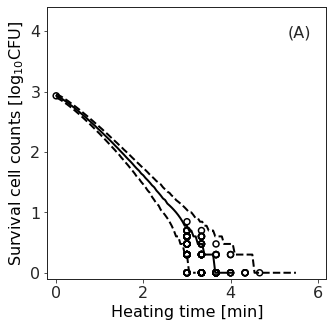

In [ ]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Heating time [min]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.2,6.2)
plt.ylim(-0.1,4.4)
plt.xticks([0,2,4,6])
plt.scatter(0,np.log10(N0),zorder=2,facecolors='none', edgecolors='k',lw=1.5)
plt.scatter(time,np.log10(N), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0)

plt.text(5.3,3.9,'(A)',fontsize=16)